In [42]:
from keras.applications.vgg16 import VGG16
from keras.utils import img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imutils import paths
import cv2
import skimage.io
import random
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
from skimage import exposure, color
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
from livelossplot.inputs.keras import PlotLossesCallback
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
import shutil
from tensorflow.keras.applications import ResNet50
from livelossplot import PlotLossesKerasTF

## **Predicción de enfermedad LLA**

En este trabajo se van a probar 3 métodos para hacer predicciones sobre un conjunto de datos de imágenes, que son: 
1. Obtención de características manualmente
2. Transfer Learning
3. Obtención de características con una CNN

### **1. Características manualmente**

Se definen funciones para calcular las características manualmente, que son la intensidad (media) y el contraste (desviación estandar)

In [2]:
def calcular_promedio_color(imagen):

    promedio_color = imagen.mean(axis=(0,1))
    std = imagen.std(axis=(0,1))

    data = {
        'intensidad_Rojo': promedio_color[0], 'contraste_Rojo': std[0],
        'intensidad_Verde': promedio_color[1], 'contraste_Verde': std[1],
        'intensidad_Azul': promedio_color[2], 'contraste_Azul': std[2]
    }

    df = pd.DataFrame(data, index=[0])

    return df

In [3]:
def media_imagen_threshold(imagen):
    img_gray = color.rgb2gray(imagen)
    img_ampliacion_rango = exposure.rescale_intensity(img_gray, in_range='image', out_range=(0, 1))
    smoothed_image = cv2.GaussianBlur(img_ampliacion_rango, (5, 5), 0)
    imagen_umbralizada_globulos_blancos = (smoothed_image > 0.25).astype(np.uint8) * 255
    imagen_umbralizada_globulos_negros = 255 - imagen_umbralizada_globulos_blancos
    media_negro = np.mean(imagen_umbralizada_globulos_negros)
    std_negro = np.std(imagen_umbralizada_globulos_negros)
    return media_negro, std_negro

Función para leer los datos de los ficheros, que están divididos en carpetas de train y test, y en carpetas según si son fotos de pacientes sanos (heathy) o no (LLA)

In [4]:
def load_data(path, norm_size):
    data = []
    label = []
    for split in ['train', 'test']:
        split_path = os.path.join(path, split)
        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            image_paths = sorted(list(paths.list_images(class_path)))
            random.seed(0)
            for each_path in image_paths:
                image = cv2.imread(each_path)
                image = cv2.resize(image, (norm_size, norm_size))
                image = img_to_array(image)
                data.append(image)
                maker = class_folder
                label.append(maker)
    data = np.array(data, dtype="float") / 255.0
    label = np.array(label)
    return data, label

In [8]:
carpeta = 'data'
lista_dfs_res = []

for subcarpeta in os.listdir(carpeta):
    ruta_subcarpeta = os.path.join(carpeta, subcarpeta)
    if os.path.isdir(ruta_subcarpeta):  
        for clase_carpeta in os.listdir(ruta_subcarpeta):
            ruta_clase_carpeta = os.path.join(ruta_subcarpeta, clase_carpeta)
            if os.path.isdir(ruta_clase_carpeta):  
                resultados = []

                for nombre_archivo in os.listdir(ruta_clase_carpeta):
                    ruta_imagen = os.path.join(ruta_clase_carpeta, nombre_archivo)
                    if os.path.isfile(ruta_imagen) and nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        imagen = skimage.io.imread(ruta_imagen)
                        df_resultado = calcular_promedio_color(imagen)
                        media_binario, std_binario = media_imagen_threshold(imagen)
                        df_resultado['intensidad_binario'] = media_binario
                        df_resultado['contraste_binario'] = std_binario
                        resultados.append(df_resultado)

                if resultados:
                    df_res = pd.concat(resultados, ignore_index=True)
                    if clase_carpeta == 'healthy':
                        df_res['label'] = 0
                    else:
                        df_res['label'] = 1
                    lista_dfs_res.append(df_res)

df = pd.concat(lista_dfs_res, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
ruta_clase_carpeta

'data\\train\\LLA'

Se dibuja un histograma para ver el threshold que utilizar para pasar la imagen a binaria

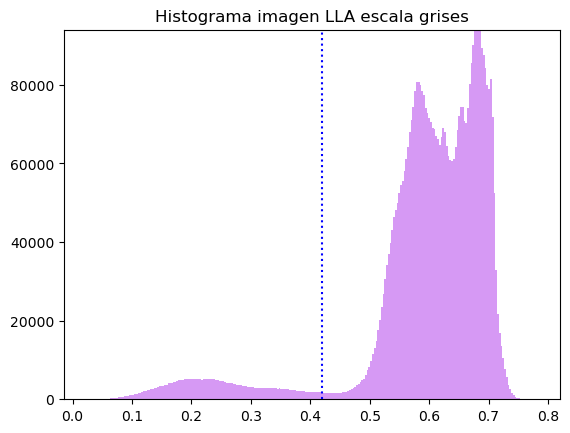

In [9]:
imagen = skimage.io.imread('data/train/LLA/Im063_1.jpg')
img_gray = color.rgb2gray(imagen)
img_ampliacion_rango = exposure.rescale_intensity(img_gray, in_range='image', out_range=(0, 1))
smoothed_image = cv2.GaussianBlur(img_ampliacion_rango, (5, 5), 0)
plt.hist(smoothed_image.ravel(), bins = 256, color = '#ae34eb', alpha = .5);
plt.vlines(0.42, 0, 95000, colors='blue', linestyles='dotted')
plt.ylim([0, 94000])
plt.title('Histograma imagen LLA escala grises')
plt.show()

Histogramas de las diferentes variables para apreciar las diferencias entre imágenes de pacientes sanos y no sanos, donde se ve que en muchas de ellas hay una distinción bastante notoria, y se puede dar por hecho que los modelos de clasificación serán capaces de aprender dichos patrones

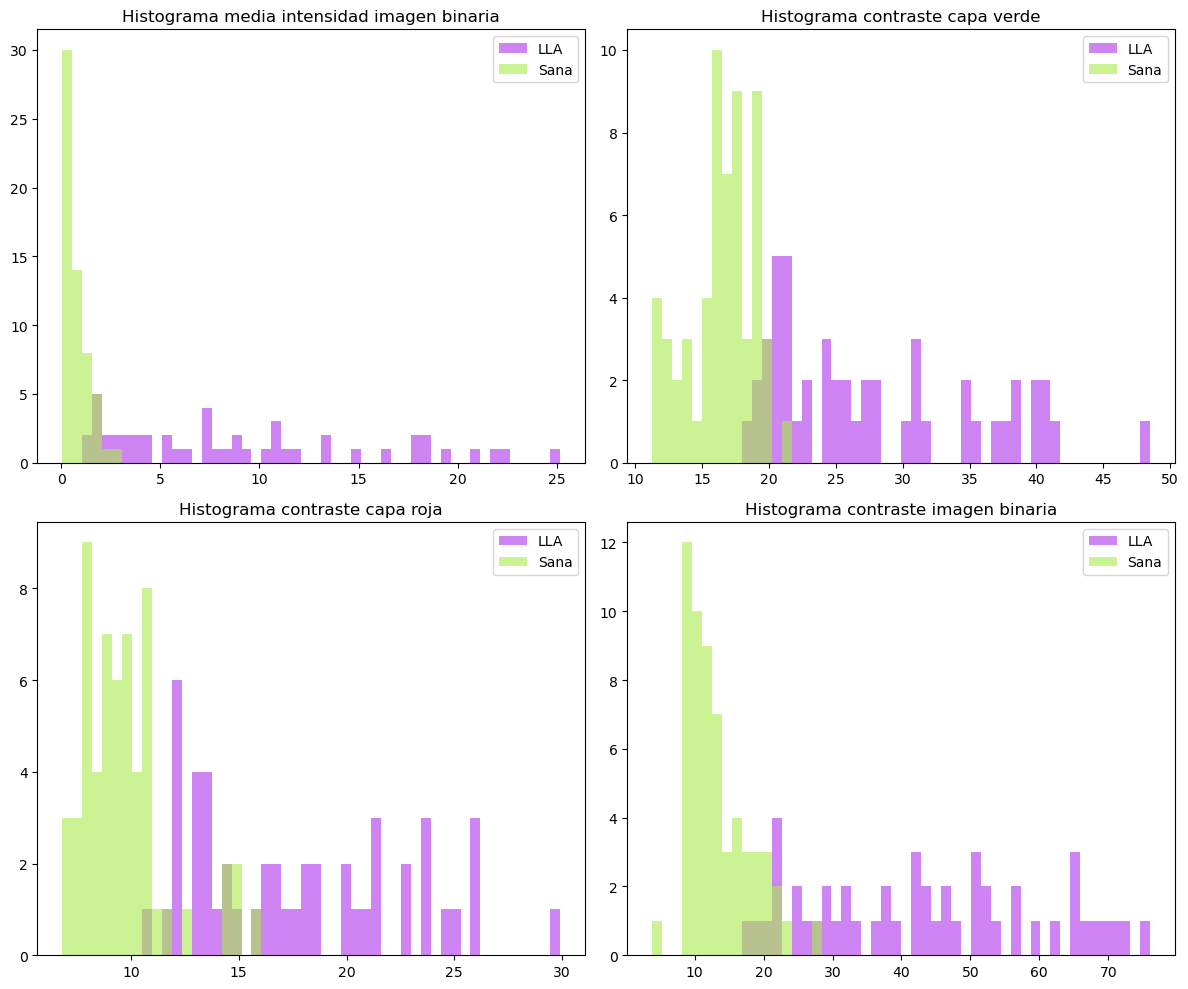

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Histograma de distribución de la media de imagen binaria
axs[0, 0].hist([df[df['label']==0]['intensidad_binario'], df[df['label']==1]['intensidad_binario']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[0, 0].set_title('Histograma media intensidad imagen binaria')
axs[0, 0].legend()

# Histograma contraste capa verde
axs[0, 1].hist([df[df['label']==0]['contraste_Verde'], df[df['label']==1]['contraste_Verde']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[0, 1].set_title('Histograma contraste capa verde')
axs[0, 1].legend()

# Histograma contraste capa roja
axs[1, 0].hist([df[df['label']==0]['contraste_Rojo'], df[df['label']==1]['contraste_Rojo']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[1, 0].set_title('Histograma contraste capa roja')
axs[1, 0].legend()

# Histograma contraste imagen binaria
axs[1, 1].hist([df[df['label']==0]['contraste_binario'], df[df['label']==1]['contraste_binario']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[1, 1].set_title('Histograma contraste imagen binaria')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [11]:
df.to_csv('dataset_features.csv', index=False)
print(df.head())

   intensidad_Rojo  contraste_Rojo  intensidad_Verde  contraste_Verde  \
0       163.581320        9.381864        149.613540        19.841740   
1       141.655424       19.929261        131.567848        31.352579   
2       146.471833       10.586638        137.199659        11.690515   
3       167.129915        7.878833        156.358288        15.875502   
4       155.119644       10.624241        146.774554        12.348570   

   intensidad_Azul  contraste_Azul  intensidad_binario  contraste_binario  \
0       137.761760       17.393865            0.539873          11.720762   
1       137.251663       17.367698           11.701175          53.356183   
2       129.107995       10.777289            0.301212           8.758896   
3       147.125746       11.644389            0.504803          11.334457   
4       139.610876       11.492035            0.360067           9.575361   

   label  
0      0  
1      1  
2      0  
3      0  
4      0  


Se utiliza el feature importance del random forest para ver qué variables son más deterministas a la hora de hacer las predicciones, y se ve que sobre todo son las variables de intensidad y contraste en blanco y negro, y el contraste en las capas rojo y verde

Precisión del modelo: 1.0000


Text(0, 0.5, 'Importancia')

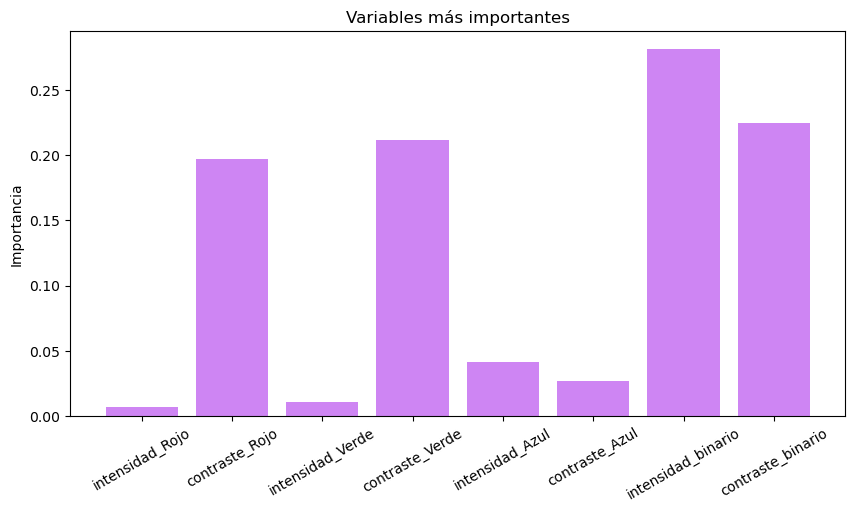

In [12]:
X = df.drop('label', axis=1)
y = df['label']

X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.2, random_state=42)

clasificador = RandomForestClassifier()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_val)

accuracy = accuracy_score(y_val, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

variables_importantes = pd.DataFrame({'variables': X_train.columns, 'importancia': clasificador.feature_importances_})
plt.figure(figsize=(10,5))
plt.bar(variables_importantes['variables'], variables_importantes['importancia'], color = '#ae34eb', alpha = .6)
plt.title('Variables más importantes')
plt.xticks(rotation = 30)
plt.ylabel('Importancia')

In [13]:
df = pd.read_csv('dataset_features.csv')

Se utiliza el df de las features creadas para hacer unos modelos, que en este caso se han probado tanto la regresión logística como el random forest, obteniendo ambos unos resultados muy positivos

In [14]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clasificador = LogisticRegression()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9091


In [15]:
coefs = pd.Series(clasificador.coef_[0], index=X.columns)

coefs_sorted = coefs.abs().sort_values(ascending=False)

print("Variables ordenadas por su aportación al modelo:")
print(coefs_sorted)

Variables ordenadas por su aportación al modelo:
contraste_binario     0.634693
intensidad_Azul       0.421089
intensidad_Rojo       0.317745
contraste_Verde       0.219249
intensidad_binario    0.100969
contraste_Rojo        0.050609
intensidad_Verde      0.032720
contraste_Azul        0.011410
dtype: float64


Prueba del modelo solo con las características más relevantes

In [16]:
X = df.drop('label', axis=1)
X = X[coefs_sorted.index[:4]]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clasificador = RandomForestClassifier()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9545


Prueba del modelo con aplicación de validación cruzada para utilizar todos los datos tanto para train como para test y así evitar que los buenos resultados sean por cómo ha salido la división de train y test

In [17]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X = df.drop('label', axis=1)
y = df['label']

clasificador_lr = LogisticRegression()
scores_lr = cross_val_score(clasificador_lr, X, y, cv=5) 
print(f"Precisión de la regresión logística con validación cruzada: {scores_lr.mean():.4f}")

clasificador_rf = RandomForestClassifier()
scores_rf = cross_val_score(clasificador_rf, X, y, cv=5)  
print(f"Precisión del RandomForestClassifier con validación cruzada: {scores_rf.mean():.4f}")


Precisión de la regresión logística con validación cruzada: 0.9909
Precisión del RandomForestClassifier con validación cruzada: 0.9909


### **2. Transfer Learning**

In [43]:
img_width = 224
img_height = 224

In [44]:
data_dir = 'data'

if not os.path.exists(os.path.join(data_dir, 'train')):
    classes = ['healthy', 'LLA']
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        src_dir = os.path.join(data_dir, cls)
        all_files = os.listdir(src_dir)
        train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
        
        for file in train_files:
            shutil.move(os.path.join(src_dir, file), os.path.join(train_dir, cls, file))
        
        for file in test_files:
            shutil.move(os.path.join(src_dir, file), os.path.join(test_dir, cls, file))

In [45]:
path_base = 'data'
train_data_dir = os.path.join(path_base, 'train')
test_data_dir = os.path.join(path_base, 'test')

#### Generadores de datos

Se crean generadores de datos utilizando ImageDataGenerator de Keras para cargar y preprocesar las imágenes en lotes durante el entrenamiento y la evaluación del modelo. Estos generadores realizan preprocesamiento de datos como normalización, aumento de datos (rotación, zoom, volteo horizontal) y división de datos de entrenamiento en entrenamiento y validación.

In [46]:
train_datagen = ImageDataGenerator(  
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True,  
    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

Ponemos un batch size de 6 ya que en el conjunto de validación únicamente hay 16 imágenes

In [47]:
batch_size=6

In [48]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    subset = 'training',
    shuffle=True,
    class_mode='categorical', 
    seed=42)

validation_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    subset='validation',
    shuffle=True, 
    class_mode='categorical',
    seed=42)

test_generator= test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height), 
    class_mode=None, 
    batch_size=1, 
    shuffle=False, 
    seed=42)

Found 70 images belonging to 2 classes.


Found 16 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


#### Creación del primer modelo base

Se carga la arquitectura InceptionV3 sin la capa densa superior (include_top=False) y se congela para que sus pesos no se actualicen durante el entrenamiento. Esto se hace para aprovechar las características aprendidas en un conjunto de datos de gran escala (ImageNet) y adaptarlas a un conjunto de datos más pequeño y específico.

Se agregan capas adicionales al final de la red para adaptarla a la tarea específica de clasificación de LLA. Esto incluye una capa de agrupamiento global (GlobalAveragePooling2D) para reducir la dimensionalidad de las características y una capa densa (Dense) con función de activación ReLU. Finalmente, se agrega otra capa densa de salida con función de activación softmax para la clasificación multiclase. El número de neuronas en la capa de salida corresponde al número de clases en el conjunto de datos, que en este caso es 2.

Por último, se muestra un resumen del modelo para revisar su arquitectura y el número de parámetros entrenables.

In [49]:
model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
model.trainable = False

In [50]:
x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [51]:
model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

#### Definición de parámetros y callbacks

In [52]:
epochs= 20
n_steps = train_generator.samples // batch_size
n_val_steps = validation_generator.samples // batch_size

In [53]:
checkpoint = ModelCheckpoint(filepath='best_weights_inceptionv2.h5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
plot_loss_1 = PlotLossesCallback()
callbacks_list = [early_stop, reduce_lr, plot_loss_1,checkpoint]

In [54]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

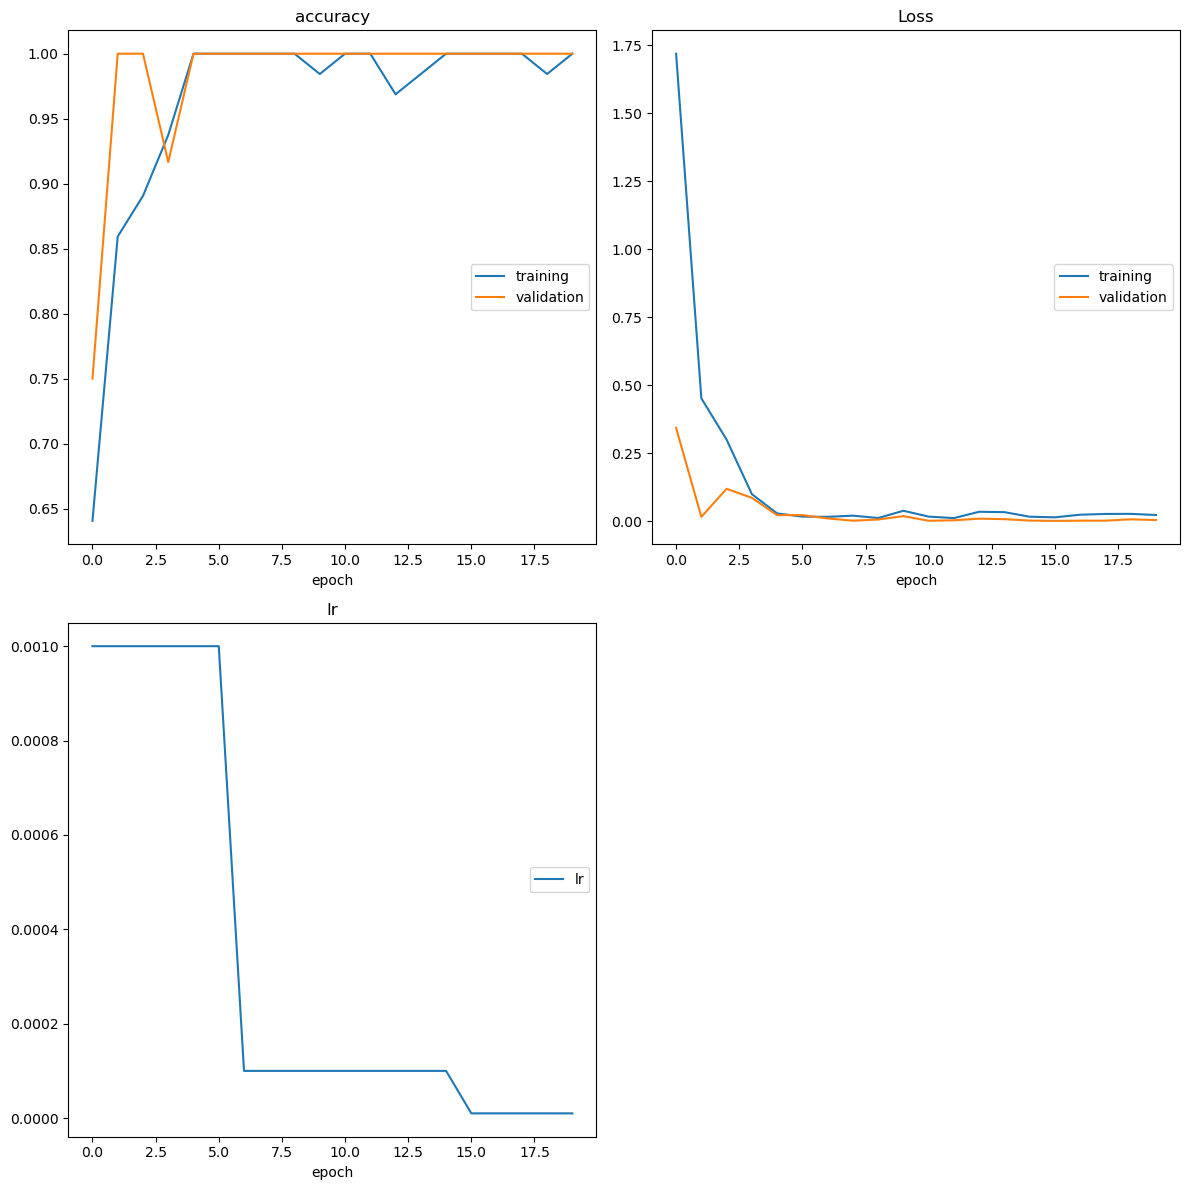

accuracy
	training         	 (min:    0.641, max:    1.000, cur:    1.000)
	validation       	 (min:    0.750, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.011, max:    1.719, cur:    0.023)
	validation       	 (min:    0.001, max:    0.343, cur:    0.004)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)

Epoch 20: val_loss did not improve from 0.00094
11/11 [==============================] - 11s 992ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000 - lr: 1.0000e-05


In [30]:
model_history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=callbacks_list
)

In [31]:
true_classes = test_generator.classes
class_indices = test_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

22/22 [==============================] - 4s 122ms/step


In [32]:
acc = accuracy_score(true_classes, pred_classes)
print("InceptionV3 Model Accuracy without Fine-Tuning: {:.2f}%".format(acc * 100))

InceptionV3 Model Accuracy without Fine-Tuning: 95.45%


### Conclusiones del modelo InceptionV2

El modelo InceptionV3 alcanzó una precisión del 95.45% sin ajuste fino, lo que indica un rendimiento sólido y una capacidad considerable para clasificar correctamente las imágenes en el conjunto de pruebas.

La gráfica de precisión muestra que tanto la precisión de entrenamiento como la de validación aumentan y se estabilizan en niveles altos, cerca del 100% para la validación. Sin embargo, hay una ligera variabilidad en la precisión de validación al principio, que se estabiliza después de unas pocas épocas. Por otro lado, la gráfica de pérdida muestra una disminución tanto en la pérdida de entrenamiento como en la de validación a lo largo de las épocas, lo cual es un buen indicador de que el modelo está aprendiendo adecuadamente.

A pesar de la alta precisión, la variabilidad inicial en la precisión de validación y las fluctuaciones en la pérdida sugieren que podría haber un riesgo de sobreajuste o inestabilidad temprana en el entrenamiento. Las técnicas de regularización y el uso de callbacks como EarlyStopping y ReduceLROnPlateau ayudan a mitigar estos efectos. El uso de EarlyStopping con restore_best_weights asegura que el modelo no entrene más de lo necesario y que se restaure el mejor conjunto de pesos. Esto previene el sobreajuste y mejora la generalización. En cuanto a el uso de ReduceLROnPlateau, este ajusta la tasa de aprendizaje basada en la pérdida de validación, lo cual ayuda a que el modelo converja más eficientemente. La combinación de estas técnicas ha contribuido a un rendimiento robusto y estable del modelo.



### Creación del segundo modelo base

Se carga la arquitectura `ResNet50` sin la capa densa superior (include_top=False) y se congela para que sus pesos no se actualicen durante el entrenamiento. Esto se hace para aprovechar las características aprendidas en un conjunto de datos de gran escala (ImageNet) y adaptarlas a un conjunto de datos más pequeño y específico.

Se agregan capas adicionales al final de la red para adaptarla a la tarea específica de clasificación de LLA. Esto incluye una capa de agrupamiento global (GlobalAveragePooling2D) para reducir la dimensionalidad de las características y una capa densa (Dense) con función de activación ReLU. Finalmente, se agrega otra capa densa de salida con función de activación softmax para la clasificación multiclase. El número de neuronas en la capa de salida corresponde al número de clases en el conjunto de datos, que en este caso es 2.

Por último, se muestra un resumen del modelo para revisar su arquitectura y el número de parámetros entrenables.

In [33]:
model_2 = ResNet50(include_top=False, input_shape=(img_width, img_height, 3))
model_2.trainable = False

In [34]:
x = GlobalAveragePooling2D()(model_2.output)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [35]:
model_2 = Model(inputs=model_2.input, outputs=output)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1_relu (Activation)     (None, 112, 112, 64)         0         ['conv1_bn[0][0]']            
          

In [36]:
model_2.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
checkpoint = ModelCheckpoint(filepath='best_weights_resnet50.h5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
plot_loss = PlotLossesKerasTF()

callbacks_list = [early_stop, reduce_lr, plot_loss, checkpoint]

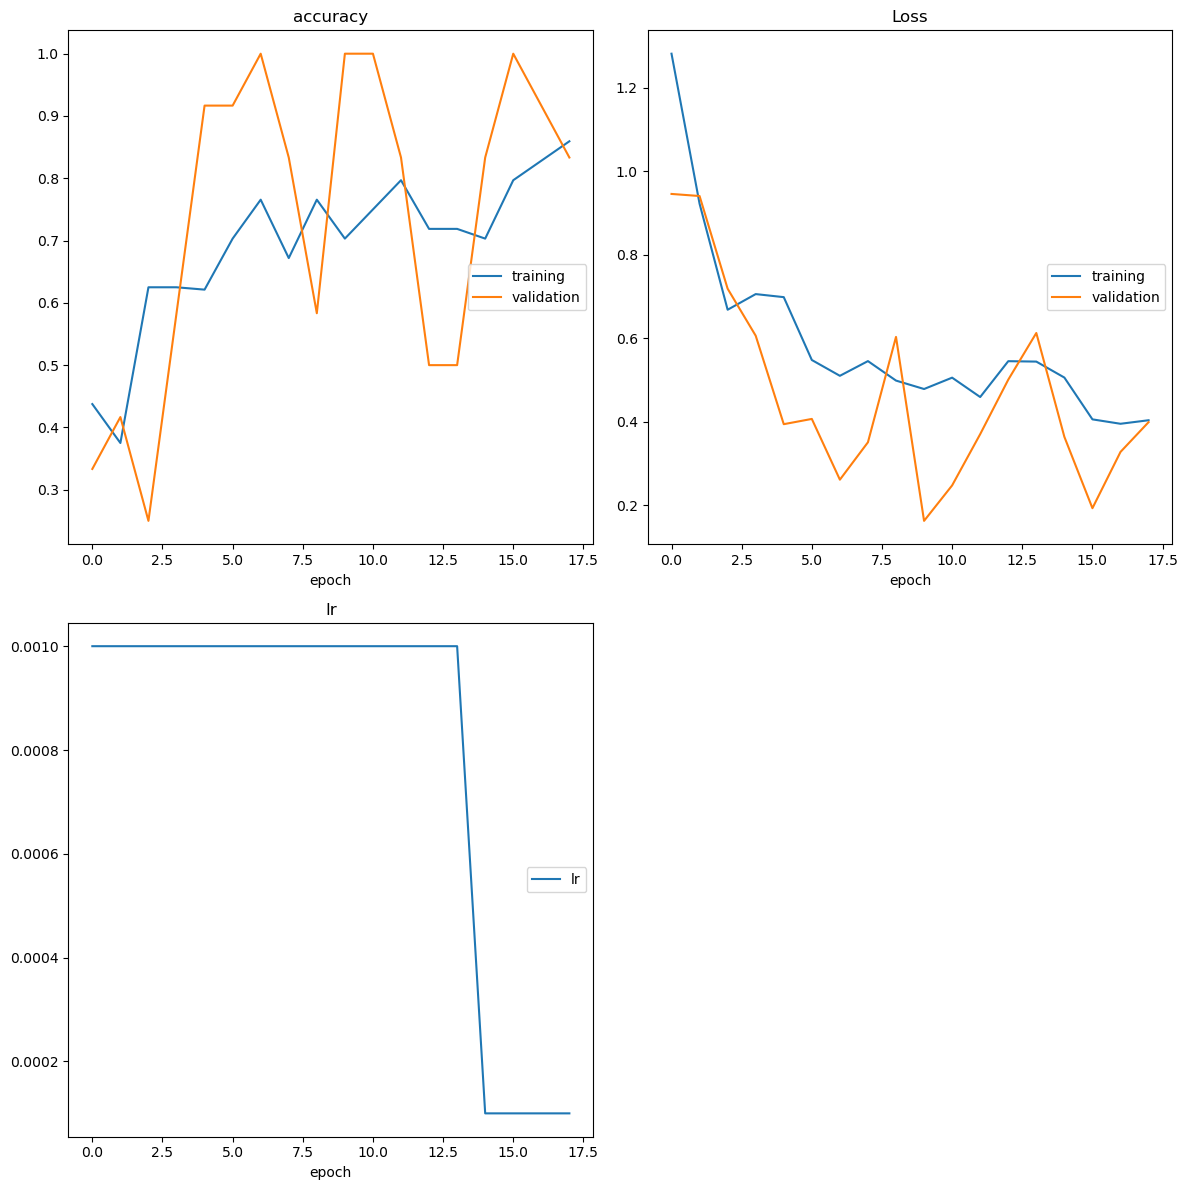

accuracy
	training         	 (min:    0.375, max:    0.859, cur:    0.859)
	validation       	 (min:    0.250, max:    1.000, cur:    0.833)
Loss
	training         	 (min:    0.395, max:    1.282, cur:    0.404)
	validation       	 (min:    0.163, max:    0.946, cur:    0.399)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)

Epoch 18: val_loss did not improve from 0.16297
11/11 [==============================] - 12s 1s/step - loss: 0.4039 - accuracy: 0.8594 - val_loss: 0.3993 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 18: early stopping


In [38]:
model_history = model_2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=callbacks_list
)

In [39]:
preds = model_2.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

acc_2 = accuracy_score(true_classes, pred_classes)
print("ResNet50 Model Accuracy without Fine-Tuning: {:.2f}%".format(acc_2 * 100))

22/22 [==============================] - 4s 153ms/step
ResNet50 Model Accuracy without Fine-Tuning: 86.36%


### Conclusiones del modelo ResNet50

El modelo ResNet50 alcanzó una precisión del 86.36% sin ajuste fino, lo que indica un rendimiento razonable pero con margen para mejoras adicionales en la clasificación de imágenes del conjunto de pruebas.

La precisión del entrenamiento muestra un aumento constante con pequeñas fluctuaciones, indicando que el modelo está aprendiendo progresivamente durante las épocas. En cuanto a la precisión de validación presenta muchas fluctuaciones, lo que sugiere inestabilidad y posibles variaciones en la capacidad del modelo para generalizar a datos no vistos.

Por otro lado, la pérdida de entrenamiento disminuye de manera constante con pequeñas fluctuaciones, señalando que el modelo está mejorando su capacidad de ajuste a los datos de entrenamiento. De la misma manera, la pérdida de validación también disminuye, pero con pequeñas fluctuaciones, lo que indica que el modelo está aprendiendo pero puede estar experimentando variabilidad en su rendimiento de validación.

De igual forma que en el anterior modelo, las técnicas de regularización y el uso de callbacks como EarlyStopping y ReduceLROnPlateau ayudan a mitigar el riesgo de sobreajuste o inestabilidad temprana en el entrenamiento debido a la variabilidad y las fluctuaciones que se observan en la precisión y perdida. 

### **3. Características con CNN**

In [55]:
path = 'data'
norm_size = 224
class_num = 2

In [56]:
data, label = load_data(path, norm_size)

Se utiliza la CNN entrenada en el punto anterior

In [57]:
# tenemos en memoria (variable model) el modelo ya cargado
n_layers = len(model.layers)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

Se cogen todos los outputs de todas las capas menos las 10 últimas de la red neuronal 

In [58]:
n_lay = 150
layer_outputs = [layer.output for layer in model.layers[:n_lay]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(data)

4/4 [==============================] - 6s 1s/step


Se obtiene una de las capas de la red, cuyos outputs se utilizarán como un df de características para utilizarlo en un modelo de ML tradicional

In [59]:
selected_layer = 50
feature_map = np.reshape(activations[selected_layer], (activations[selected_layer].shape[0], -1))
print(f"Forma del mapa de características: {feature_map.shape}")

Forma del mapa de características: (108, 160000)


In [60]:
random.seed(0)
feature_map, label = zip(*random.sample(list(zip(feature_map, label)), len(label)))
X_train, X_test, y_train, y_test = train_test_split(feature_map, label, test_size=0.3, random_state=42)
len(X_train), len(X_test)

(75, 33)

In [61]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

Se prueban como modelos de clasificación tanto un Super Vector Machine (SVM) como un Random Forest  

In [62]:
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC()
}

In [63]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [64]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

Se hace una búsqueda de hiperparámetros para ambos modelos y así ver la mejor combinación para cada uno

In [65]:
best_estimators = {}
for name, clf in classifiers.items():
    if name == 'RandomForest':
        grid = GridSearchCV(clf, param_grid_rf, cv=3, scoring='accuracy')
    elif name == 'SVM':
        grid = GridSearchCV(clf, param_grid_svm, cv=3, scoring='accuracy')
    
    grid.fit(X_train, y_train_enc)
    best_estimators[name] = grid.best_estimator_
    print(f"Mejores parámetros para {name}: {grid.best_params_}")

Mejores parámetros para RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mejores parámetros para SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


Se hacen predicciones con ambos modelos sobre los datos de test y se comparan con las etiquetas reales de estos datos. Se puede ver que los resultados obtenidos con ambos son muy buenos, ya que solo comete 2 errores entre más de 30 instancias

Evaluando RandomForest...
Matriz de confusión para RandomForest:


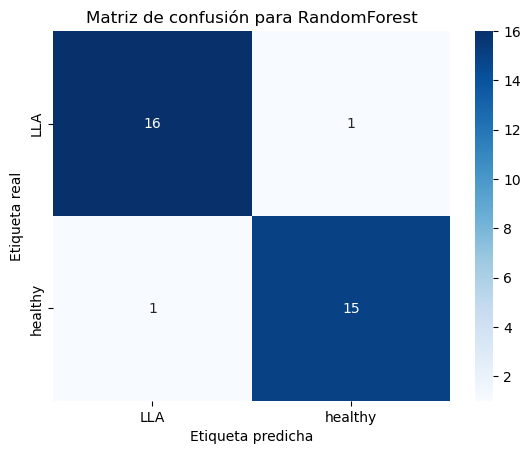

Informe de clasificación para RandomForest:
              precision    recall  f1-score   support

         LLA       0.94      0.94      0.94        17
     healthy       0.94      0.94      0.94        16

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33

Accuracy para RandomForest: 0.9393939393939394
Evaluando SVM...
Matriz de confusión para SVM:


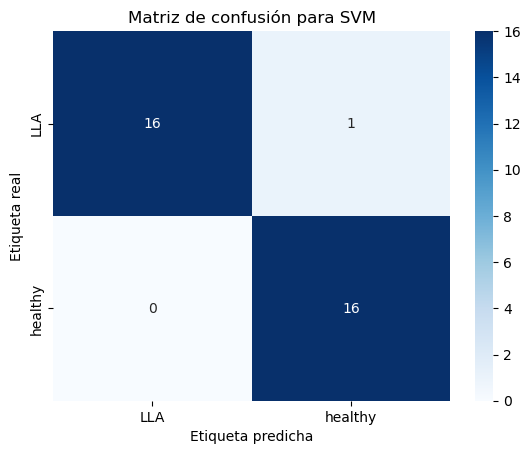

Informe de clasificación para SVM:
              precision    recall  f1-score   support

         LLA       1.00      0.94      0.97        17
     healthy       0.94      1.00      0.97        16

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

Accuracy para SVM: 0.9696969696969697


In [66]:
for name, clf in best_estimators.items():
    print(f"Evaluando {name}...")
    predictions = clf.predict(X_test)
    print(f"Matriz de confusión para {name}:")
    cm = confusion_matrix(y_test_enc, predictions)
    df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title(f'Matriz de confusión para {name}')
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.show()
    
    print(f"Informe de clasificación para {name}:")
    print(classification_report(y_test_enc, predictions, target_names=le.classes_))

    accuracy = accuracy_score(y_test_enc, predictions)
    print(f"Accuracy para {name}: {accuracy}")

## **Comparación de los modelos**

Por último se muestran los resultados obtenidos con cada uno de los métodos para tener de una forma más visual los resultados de todos

In [72]:
print(f"1. Precisión de las características de forma manual con validación cruzada: {scores_lr.mean():.4f}")

print(f"2. Precisión de la predicción con la CNN creada: {acc:.4f}")

print(f"3. Precisión de las características obtenidas con la CNN creada: {accuracy:.4f}")

1. Precisión de las características de forma manual con validación cruzada: 0.9909
2. Precisión de la predicción con la CNN creada: 0.9545
3. Precisión de las características obtenidas con la CNN creada: 0.9697
